In [1]:
import pandas as pd
import re
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,  BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

2025-08-07 13:28:26.700711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754573306.905402      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754573306.959566      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# Đọc file dataset
file_path = r"/kaggle/input/dataset-url-20000/final_dataset_urls.csv"
df = pd.read_csv(file_path)

# Xem qua dữ liệu
print("Trước xử lý:", df.head())

# Hàm chuẩn hóa URL
def normalize_url(url: str):
    url = str(url).strip().lower()
    # Bỏ http:// hoặc https://
    url = re.sub(r'^https?:\/\/', '', url)
    return url

# Áp dụng chuẩn hóa
df['url'] = df['url'].apply(normalize_url)

# Giữ lại cột url và label
df = df[['url','label']]

print(df.head(10))


Trước xử lý:                                        url      label
0     ewaybillgst.gov.in/download/settings     benign
1    https://annadegismen.com/js/tpwqro.js  malicious
2  http://160.187.246.23/huhu/titanjr.i486  malicious
3                      parade.com/lj86/faq     benign
4   samsungcloud.com/h10gn/login?ref=yi48n     benign
                                                 url      label
0               ewaybillgst.gov.in/download/settings     benign
1                      annadegismen.com/js/tpwqro.js  malicious
2                   160.187.246.23/huhu/titanjr.i486  malicious
3                                parade.com/lj86/faq     benign
4             samsungcloud.com/h10gn/login?ref=yi48n     benign
5             warnerbros.com/6185rdoh/cart/gtqa/docs     benign
6  raw.githubusercontent.com/uelenka/supreme-spor...  malicious
7                          burger042.ddnsfree.com/zz  malicious
8                                     fatalmodel.com     benign
9         screenconnect

In [3]:
label_map = {'benign': 0, 'malicious': 1}
df['label_num'] = df['label'].map(label_map)

X = df['url']
y = df['label_num']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Số lượng tập train/test:", len(X_train), len(X_test))


Số lượng tập train/test: 16004 4001


In [5]:
max_len = 200  # URL tối đa 200 ký tự
tokenizer = Tokenizer(char_level=True)  # Token theo ký tự
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


In [6]:
max_length = max_len           # đã biết sẵn là 200
vocab_size = len(tokenizer.word_index) + 1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(1, activation='sigmoid')
])

# Compile với learning rate tùy chỉnh
optimizer = Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1754573321.796601      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
# Đảm bảo y_train là int hoặc float
y_train = np.array(y_train).astype(int)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights))

# print("Class weights:", class_weights)
# history = model.fit(
#     X_train_pad, y_train, 
#     epochs=100, 
#     batch_size=64, 
#     class_weight=class_weights,
#     validation_split=0.2
# )
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train mô hình
history = model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=64,
    class_weight=class_weights,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.8251 - loss: 0.7106 - val_accuracy: 0.9469 - val_loss: 0.3603
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.9764 - loss: 0.2398 - val_accuracy: 0.9866 - val_loss: 0.1322
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.9829 - loss: 0.1198 - val_accuracy: 0.9909 - val_loss: 0.0699
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.9906 - loss: 0.0665 - val_accuracy: 0.9922 - val_loss: 0.0480
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.9914 - loss: 0.0504 - val_accuracy: 0.9909 - val_loss: 0.0471
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.9913 - loss: 0.0463 - val_accuracy: 0.9919 - val_loss: 0.0381
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.9940 - loss: 0.0336 - val_accuracy: 0.9934 - val_loss: 0.0344
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.9937 - loss: 0.0321 - val_accu

In [8]:
import numpy as np

X_test_pad = np.array(X_test_pad, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

loss, acc = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Độ chính xác trên tập test: {acc*100:.2f}%")


126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - accuracy: 0.9980 - loss: 0.0165
Độ chính xác trên tập test: 99.75%


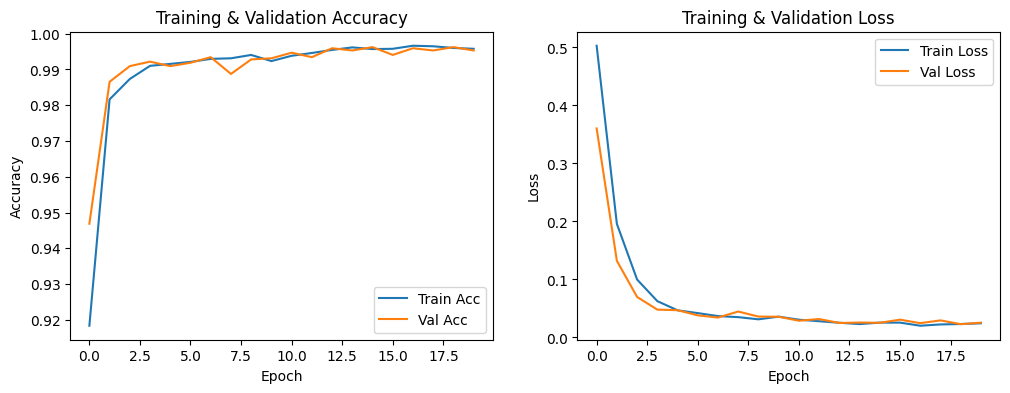

In [9]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 318ms/step


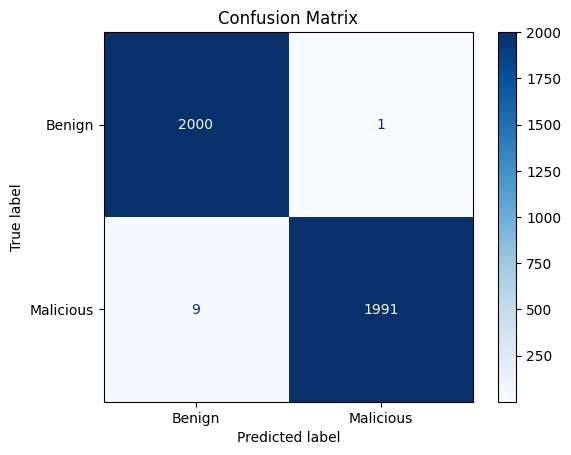

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dự đoán nhãn trên tập test
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


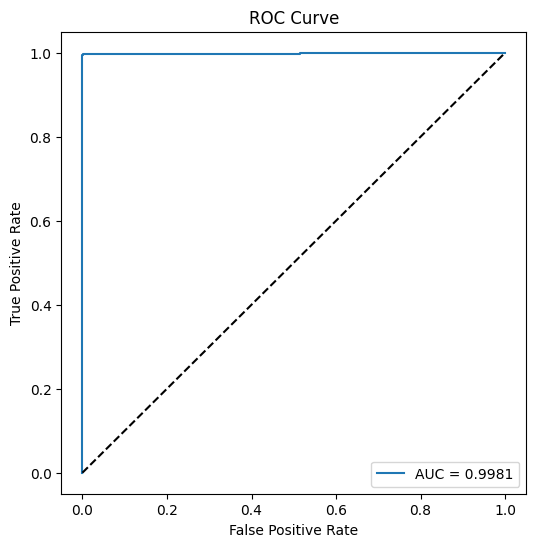

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [12]:
def predict_url(url):
    url = normalize_url(url)
    seq = tokenizer.texts_to_sequences([url])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad)[0][0]
    return "malicious" if pred >= 0.5 else "benign"


print(predict_url("https://www.youtube.com/watch?v=P4Ovu-riNBQsad"))
print(predict_url("https://annadegismen.com/js/tpwqro.js"))
print(predict_url("https://vlxx.com/js/tpwqro"))
print(predict_url("https://vnepress.com/"))
print(predict_url("https://sv.haui.edu.vn/"))
print(predict_url("https://taquoctuan.net/download.exe"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
malicious
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
malicious
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
malicious


In [13]:
# Lưu mô hình theo định dạng mới (.keras)
model.save('/kaggle/working/url_lstm_model.keras')

print("✅ Đã lưu mô hình mới vào /kaggle/working/url_lstm_model.keras")

# ✅ Lưu tokenizer
import pickle

with open('/kaggle/working/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("✅ Đã lưu tokenizer.")


✅ Đã lưu mô hình mới vào /kaggle/working/url_lstm_model.keras
✅ Đã lưu tokenizer.
